<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import re
import torch
import transformers
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from nltk.corpus import stopwords as nltk_stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from tqdm import notebook

In [2]:
try:
    df = pd.read_csv('/datasets/toxic_comments.csv')
except:
    df = pd.read_csv('D:\\yandex_practicum\\проекты\\проект 11\\toxic_comments.csv')

In [3]:
df.head()

In [4]:
df.info()

In [5]:
df.describe()

In [6]:
df['toxic'] = df['toxic'].astype('int8')

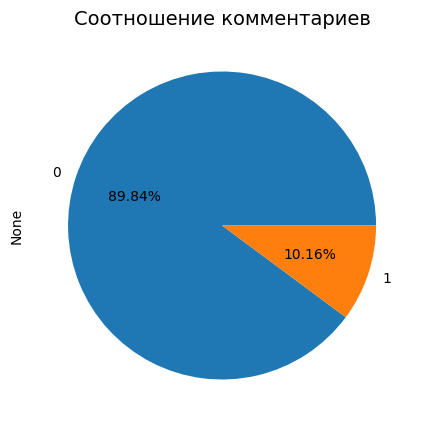

In [7]:
df.value_counts('toxic').plot(kind='pie', figsize=(5,5), autopct='%1.2f%%')
plt.title('Cоотношение комментариев', fontsize=14);
df.value_counts('toxic')

In [8]:
corpus = df['text'].values

In [9]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

In [10]:
stopwords = set(nltk_stopwords.words('english'))

In [11]:
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)

In [12]:
def token_lemmatize(text):
    mnl = nltk.WordNetLemmatizer()
    words_list = word_tokenize(text)
    lemm_list = [mnl.lemmatize(word, get_wordnet_pos(word)) for word in words_list]
    lemm_text = " ".join(lemm_list)
    return lemm_text

In [13]:
def clear_text(text):
    text = re.sub(r'[^a-zA-Z ]', ' ', text)
    text = text.split()
    return " ".join(text)

In [14]:
corpus_lemm = [token_lemmatize(clear_text(corpus[i])) for i in range(len(corpus))]

In [15]:
RANDOM_STATE = 42

In [16]:
features_train, features_test, target_train, target_test = train_test_split(corpus_lemm, df['toxic'], 
                                                                            test_size=0.2, 
                                                                            random_state=RANDOM_STATE)
target_train.shape, target_test.shape

In [17]:
len(features_train), len(features_test)

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

**Вывод по разделу:**

Данные загружены, создан корпус, тексты очищены от лишних символов, стоп-слов, токенизированы и лемматизированы. Созданы обучающая и тестовая выборки. Признаки векторизованы методом TF-IDF. Обнаружен дисбаланс классов.

## Обучение

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

Проверим значение f1, если все предсказания **toxic** будут равны 0.

In [21]:
pred_zero = pd.Series(data=np.zeros(len(target_train)), index=target_train.index, dtype='int8')
print(f'F1-мера константной модели на обучающей выборке равна {f1_score(target_train, pred_zero)}')

In [22]:
# пайплайны для векторизации и LogisticRegression, LinearSVC, RandomForestClassifier
pipe_lr = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)), 
                    ('clf', LogisticRegression(class_weight='balanced', random_state=RANDOM_STATE))])

pipe_lsvc = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                      ('clf', LinearSVC(class_weight='balanced', random_state=RANDOM_STATE))])

pipe_rfc = Pipeline([('tfidf', TfidfVectorizer(stop_words=stopwords)),
                     ('clf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))])
# подбираемые в GridSearchCV гиперпараметры
grid_params_lr = [{'clf__C': np.linspace(0.5, 20, 12), 
                  'clf__max_iter':[1000, 1200]}]

grid_params_lsvc = [{'clf__C': np.linspace(0.5, 20, 12),
                    'clf__max_iter':[1000, 1200]}]

grid_params_rfc = [{'clf__n_estimators': [50, 100], 
                    'clf__max_depth':[3, 6]}]
# создание GridSearchCV для разных моделей
LR = GridSearchCV(estimator=pipe_lr, 
                  cv=3, 
                  param_grid=grid_params_lr, 
                  scoring='f1')

LSVC = GridSearchCV(estimator=pipe_lsvc, 
                    cv=3, 
                    param_grid=grid_params_lsvc, 
                    scoring='f1')

RFC = GridSearchCV(estimator=pipe_rfc, 
                   cv=3, 
                   param_grid=grid_params_rfc, 
                   scoring='f1')
# список пайплайнов для итерации
grids = [LR, LSVC, RFC]
grids_dict = {0: 'LogisticRegression', 
              1: 'LinearSVC', 
              2: 'RandomForestClassifier'}
# худшее значение F1
best_f1 = 0

In [25]:
%%time
for idx, gs in enumerate(grids):
    print('_' * 20)
    print(f'Модель: {grids_dict[idx]}')
    # обучаем модель
    gs.fit(features_train, target_train)
    # параметры лучшей модели
    print(f'Лучшие параметры: {gs.best_params_}')
    print(f'Лучшее значение F1-меры: {gs.best_score_}')
    if gs.best_score_ > best_f1:
        best_f1 = gs.best_score_
        best_gs = gs
        best_gs_idx = idx
print('_' * 20)      
print(f'Лучшая модель: {grids_dict[best_gs_idx]}')
pred = best_gs.predict(features_test)
print(f'Значение F1-меры на тестовой выборке: {f1_score(target_test, pred)}')

<div style="background-color:black; color:#ffffff; text-align:left; padding:2%">

**Вывод по разделу:**    
Обучены 3 модели при помощи *GridSearchCV*: **LogisticRegression, LinearSVC, RandomForestClassifier**. Лучшей оказалась **LogisticRegression**. F1-мера константной модели равна 0.

## Выводы

* Данные о токсичных комментариях загружены и обработаны с помощью:
    * регулярных выражений
    * nltk.word_tokenize
    * nltk.WordNetLemmatizer
    * nltk_stopwords
    * TfidfVectorizer
* Обучены 3 модели при помощи GridSearchCV:
| Модель | F1-мера |
|:-|-|
| LogisticRegression | 0.758 |
| LinearSVC | 0.755 |
| RandomForestClassifier | 0.343 |
* Лучшая модель - **LogisticRegression**. Параметры лучшей модели:
    * C: 7.590909090909091
    * max_iter: 1000
* F1-мера константной модели равна 0.